# <center> Predicting Flight Ticket Prices </center>

# Table of Contents:
* ## [Introduction](#introduction)

* ## [Scraped Data EDA](#eda)

* ## [Handling Categorical Data](#cat_data)

* ## [Features](#features)

* ## [Modeling](#modeling)

* ## [Saving The Final Model](#model)

## Introduction: <a class="anchor" id="introduction"></a>

<b> This is the main notebook for the flight price prediction project. We predict ticket prices for upcoming flights to help customers in selecting the optimum time for travel and the cheapest flight to the desired destination. The data of the project which is used to train the models is scraped from [Kayak](http://www.kayak.com) which is detailed in the "kayak-scraper" notebook. </b>

### Importing necessarry libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics

In [2]:
!git clone https://github.com/MeshalAlamr/flight-price-prediction.git

Cloning into 'flight-price-prediction'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 114 (delta 34), reused 92 (delta 18), pack-reused 3 (from 1)
Receiving objects: 100% (114/114), 19.82 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (34/34), done.


## Scraped Data EDA: <a class="anchor" id="eda"></a>
### Loading the scraped data

In [3]:
df_1 = pd.read_csv("flight-price-prediction/data/PAR_NYC.csv")
df_2 = pd.read_csv("flight-price-prediction/data/PAR_SVO.csv")
df_3 = pd.read_csv("flight-price-prediction/data/SVO_NYC.csv")
df_4 = pd.read_csv("flight-price-prediction/data/SVO_RUH.csv")
df_5 = pd.read_csv("flight-price-prediction/data/NYC_PAR.csv")
df_6 = pd.read_csv("flight-price-prediction/data/NYC_SVO.csv")
df_7 = pd.read_csv("flight-price-prediction/data/RUH_NYC.csv")
df_8 = pd.read_csv("flight-price-prediction/data/RUH_PAR.csv")
df_9 = pd.read_csv("flight-price-prediction/data/RUH_SVO.csv")
df_10 = pd.read_csv("flight-price-prediction/data/SVO_PAR.csv")
df_11 = pd.read_csv("flight-price-prediction/data/PAR_RUH.csv")
df_12 = pd.read_csv("flight-price-prediction/data/NYC_RUH.csv")

In [4]:
print(f"{df_1['Source'][0]} => {df_1['Destination'][0]} route has {df_1.shape[0]} trips")
print(f"{df_2['Source'][0]} => {df_2['Destination'][0]} route has {df_2.shape[0]} trips")
print(f"{df_3['Source'][0]} => {df_3['Destination'][0]} route has {df_3.shape[0]} trips")
print(f"{df_4['Source'][0]} => {df_4['Destination'][0]} route has {df_4.shape[0]} trips")
print(f"{df_5['Source'][0]} => {df_5['Destination'][0]} route has {df_5.shape[0]} trips")
print(f"{df_6['Source'][0]} => {df_6['Destination'][0]} route has {df_6.shape[0]} trips")
print(f"{df_7['Source'][0]} => {df_7['Destination'][0]} route has {df_7.shape[0]} trips")
print(f"{df_8['Source'][0]} => {df_8['Destination'][0]} route has {df_8.shape[0]} trips")
print(f"{df_9['Source'][0]} => {df_9['Destination'][0]} route has {df_9.shape[0]} trips")
print(f"{df_10['Source'][0]} => {df_10['Destination'][0]} route has {df_10.shape[0]} trips")
print(f"{df_11['Source'][0]} => {df_11['Destination'][0]} route has {df_11.shape[0]} trips")
print(f"{df_12['Source'][0]} => {df_12['Destination'][0]} route has {df_12.shape[0]} trips")

PAR => NYC route has 14881 trips
PAR => SVO route has 2403 trips
SVO => NYC route has 4202 trips
SVO => RUH route has 2235 trips
NYC => PAR route has 5334 trips
NYC => SVO route has 1905 trips
RUH => NYC route has 7279 trips
RUH => PAR route has 553 trips
RUH => SVO route has 2725 trips
SVO => PAR route has 3314 trips
PAR => RUH route has 7327 trips
NYC => RUH route has 3205 trips


### Defining functions to clean the data

In [5]:
def clean_duration(duration):
    duration = list(duration)
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(str(duration[i]).split(sep = "h")[0])) # Extract hours from duration
        duration_mins.append(int(str(duration[i]).split(sep = "m")[0].split()[-1])) # Extracts only minutes from duration

    d = []
    for i in range(len(duration)):
        d.append(duration_hours[i]*60+duration_mins[i])

    return d

# convert price to numerical format in USD
def clean_price(price):
    price = price.astype(str)  # Convert the column to string type
    price = price.str.replace(',','',regex=True)
    price = price.str.replace('SAR','',regex=True)
    price = price.str.strip()
    price = round(pd.to_numeric(price)/3.75,2)
    return price

# convert date to datetime format
def clean_date(date):
    date = pd.to_datetime(date)
    return date

# get price quantile to deal with outliers
def get_price_quantile(price):
    Q1 = price.quantile(0.25)
    Q3 = price.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    return (lower_lim,upper_lim)

# get average of each airline
def get_avg_per_airline(x):
    # average for trips with multiple airlines
    print("FUCKING ---->")
    print(x)
    print("<------FUCKING")
    multiple_airlines = x[x["Airline"].str.contains(",")]
    print("___multiple_airlines___")
    print(multiple_airlines)
    b = list(multiple_airlines["Airline"].str.split(","))
    print("___b___")
    print(b)
    d = [] # Airline 1
    e = [] # Airline 2
    for i in range(len(b)):
        d.append(b[i][0])
        e.append(b[i][1])
    for i in range(len(e)):
        e[i] = e[i].strip()
    m_airlines = list(set(d)) + list(set(e))
    column_names = ["Airline", "Average Price"]
    t_ = pd.DataFrame(columns = column_names)
    for airline in m_airlines:
        t = pd.DataFrame(x[x["Airline"].str.contains(airline)]["Airline"])
        t["Average Price"] = x[x["Airline"].str.contains(airline)]["Price"].mean()
        #t_ = t_.append(t)
        t_ = pd.concat([t_, t], ignore_index=True)
    t__ = t_.groupby("Airline",as_index = False)["Average Price"].mean()
    k = multiple_airlines.copy()
    k = k.merge(t__, on = "Airline", how = "left")

    # average for trips with single airlines
    single_airlines = x[~x["Airline"].str.contains(",")]
    avg_per_airline = single_airlines.groupby("Airline", as_index = False)["Price"].mean()
    avg_per_airline = avg_per_airline.rename(columns={"Price" : "Average Price"})
    temp = single_airlines.copy()
    temp = temp.merge(avg_per_airline, on='Airline', how ="left")

    temp_1 = temp.groupby("Airline", as_index = False)["Average Price"].mean()
    k_1 = k.groupby("Airline", as_index = False)["Average Price"].mean()
    k_temp = pd.concat([k_1,temp_1])
    y = x.merge(k_temp, on = "Airline")

    return y



In [6]:
dfs_array = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12]

In [7]:
# cleaning the data
dfs_array_output = []
for df in dfs_array:
    df.drop_duplicates() # drop duplicate rows
    df["Duration"] = clean_duration(df["Duration"]) # convert duration to numerical minutes format
    df["Price"] = clean_price(df["Price"]) # convert price to numerical format in USD
    df["Date"] = clean_date(df["Date"]) # convert date to datetime format
    dfs_array_output.append(get_avg_per_airline(df)) # get average per airline


FUCKING ---->
                       Airline Source Destination  Duration Total stops  \
0             TAP AIR PORTUGAL    PAR         NYC       770     1 stop    
1                       Iberia    PAR         NYC       520    nonstop    
2      Air Transat, Air Canada    PAR         NYC       699     1 stop    
3            Brussels Airlines    PAR         NYC       500    nonstop    
4                   Air France    PAR         NYC       505    nonstop    
...                        ...    ...         ...       ...         ...   
14876                  Finnair    PAR         NYC       780     1 stop    
14877           Etihad Airways    PAR         NYC      1420     1 stop    
14878               Aeromexico    PAR         NYC      1215     1 stop    
14879           Cathay Pacific    PAR         NYC      1755     1 stop    
14880           Cathay Pacific    PAR         NYC      1830     1 stop    

         Price       Date  
0       379.47 2022-02-01  
1       412.53 2022-02-01  
2

/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)


FUCKING ---->
                Airline Source Destination  Duration Total stops    Price  \
0            Air Serbia    PAR         SVO       375     1 stop    206.40   
1              Aeroflot    PAR         SVO       225    nonstop    308.00   
2              Aeroflot    PAR         SVO       250    nonstop    315.73   
3              Aeroflot    PAR         SVO       235    nonstop    321.87   
4               Finnair    PAR         SVO       440     1 stop    157.07   
...                 ...    ...         ...       ...         ...      ...   
2398                KLM    PAR         SVO       335     1 stop    328.53   
2399  Brussels Airlines    PAR         SVO       325     1 stop    149.60   
2400         Air Serbia    PAR         SVO       600     1 stop    173.60   
2401                KLM    PAR         SVO       335     1 stop    328.53   
2402      Qatar Airways    PAR         SVO       825     1 stop   1620.00   

           Date  
0    2022-02-01  
1    2022-02-01  
2    20

/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)
/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)


FUCKING ---->
                Airline Source Destination  Duration Total stops    Price  \
0              Aeroflot    SVO         NYC       615    nonstop    265.07   
1              Aeroflot    SVO         NYC       615    nonstop    247.73   
2              Aeroflot    SVO         NYC       615    nonstop    247.73   
3                 Delta    SVO         NYC       865     1 stop    278.40   
4                 Delta    SVO         NYC       910     1 stop    278.40   
...                 ...    ...         ...       ...         ...      ...   
4197  Multiple Airlines    SVO         NYC       975    2 stops   5241.87   
4198  Multiple Airlines    SVO         NYC      1035    2 stops   5241.87   
4199  Multiple Airlines    SVO         NYC      1035    2 stops   5241.87   
4200  Multiple Airlines    SVO         NYC      1115    2 stops   5241.87   
4201  Multiple Airlines    SVO         NYC      1115    2 stops   5241.87   

           Date  
0    2022-02-01  
1    2022-02-01  
2    20

/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)
/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)


FUCKING ---->
                               Airline Source Destination  Duration  \
0                           Air France    NYC         PAR       440   
1                           Air France    NYC         PAR       440   
2                           Air France    NYC         PAR       440   
3                           Air France    NYC         PAR       430   
4                           Air France    NYC         PAR       440   
...                                ...    ...         ...       ...   
5329  United Airlines, British Airways    NYC         PAR       615   
5330                             Delta    NYC         PAR       645   
5331                             Delta    NYC         PAR       800   
5332                        Air Canada    NYC         PAR       765   
5333                        Air Canada    NYC         PAR       765   

     Total stops    Price       Date  
0       nonstop    274.93 2022-02-01  
1       nonstop    274.93 2022-02-01  
2       nonstop 

/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)
/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)


FUCKING ---->
              Airline Source Destination  Duration Total stops    Price  \
0     British Airways    RUH         PAR       630     1 stop    285.87   
1    Turkish Airlines    RUH         PAR       780     1 stop    413.60   
2      Etihad Airways    RUH         PAR       630     1 stop    488.53   
3       Qatar Airways    RUH         PAR       655     1 stop    512.00   
4            Emirates    RUH         PAR       700     1 stop    540.80   
..                ...    ...         ...       ...         ...      ...   
548             SWISS    RUH         PAR       775    2 stops    978.40   
549          Emirates    RUH         PAR      1406    2 stops   3214.93   
550         Egypt Air    RUH         PAR       580     1 stop    262.93   
551  Pegasus Airlines    RUH         PAR       545     1 stop    272.80   
552          Oman Air    RUH         PAR       960     1 stop    555.47   

          Date  
0   2022-02-02  
1   2022-02-02  
2   2022-02-02  
3   2022-02-02  


/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)
/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)


FUCKING ---->
                Airline Source Destination  Duration Total stops    Price  \
0            Air Serbia    SVO         PAR      1520     1 stop    134.40   
1            Air France    SVO         PAR       250    nonstop    162.13   
2            Air Serbia    SVO         PAR      1520     1 stop    115.47   
3            Air France    SVO         PAR       245    nonstop    276.80   
4            Air France    SVO         PAR       250    nonstop    276.80   
...                 ...    ...         ...       ...         ...      ...   
3309            Finnair    SVO         PAR       335     1 stop    149.07   
3310                LOT    SVO         PAR       320     1 stop    194.13   
3311                KLM    SVO         PAR       365     1 stop    224.27   
3312  Brussels Airlines    SVO         PAR      1005     1 stop    154.67   
3313      Qatar Airways    SVO         PAR       855     1 stop   1554.13   

           Date  
0    2022-02-01  
1    2022-02-01  
2    20

/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)


FUCKING ---->
                           Airline Source Destination  Duration Total stops  \
0                        Lufthansa    PAR         RUH       550     1 stop    
1                           SAUDIA    PAR         RUH       350    nonstop    
2                  Ryanair, flynas    PAR         RUH      2285    3 stops    
3                        Lufthansa    PAR         RUH       550     1 stop    
4                        Lufthansa    PAR         RUH       610     1 stop    
...                            ...    ...         ...       ...         ...   
7322  Austrian Airlines, Egypt Air    PAR         RUH       965    2 stops    
7323          Lufthansa, Egypt Air    PAR         RUH       830    2 stops    
7324          Lufthansa, Egypt Air    PAR         RUH       950    2 stops    
7325       British Airways, SAUDIA    PAR         RUH       755     1 stop    
7326     Egypt Air, Etihad Airways    PAR         RUH       970    2 stops    

        Price       Date  
0      420

/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)


FUCKING ---->
              Airline Source Destination  Duration Total stops   Price  \
0      Etihad Airways    NYC         RUH       945     1 stop   579.47   
1      Etihad Airways    NYC         RUH       945     1 stop   554.13   
2      Etihad Airways    NYC         RUH      1315     1 stop   554.13   
3           Egypt Air    NYC         RUH      1120     1 stop   661.07   
4     Royal Jordanian    NYC         RUH       850     1 stop   685.33   
...               ...    ...         ...       ...         ...     ...   
3200        Lufthansa    NYC         RUH      1165    2 stops   930.67   
3201        Lufthansa    NYC         RUH      1130    2 stops   934.67   
3202            SWISS    NYC         RUH      1145    2 stops   935.73   
3203        Lufthansa    NYC         RUH      1095    2 stops   936.00   
3204        Lufthansa    NYC         RUH      1095    2 stops   936.00   

           Date  
0    2022-02-01  
1    2022-02-01  
2    2022-02-01  
3    2022-02-01  
4    20

/tmp/ipython-input-4254129517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t_ = pd.concat([t_, t], ignore_index=True)


In [8]:
dfs_array_output[2]

,Airline,Source,Destination,Duration,Total stops,Price,Date,Average Price
0,Aeroflot,SVO,NYC,615,nonstop,265.07,2022-02-01,254.677541
1,Aeroflot,SVO,NYC,615,nonstop,247.73,2022-02-01,254.677541
2,Aeroflot,SVO,NYC,615,nonstop,247.73,2022-02-01,254.677541
3,Delta,SVO,NYC,865,1 stop,278.40,2022-02-01,532.747689
4,Delta,SVO,NYC,910,1 stop,278.40,2022-02-01,532.747689
...,...,...,...,...,...,...,...,...
4197,Multiple Airlines,SVO,NYC,975,2 stops,5241.87,2022-04-30,4220.968312
4198,Multiple Airlines,SVO,NYC,1035,2 stops,5241.87,2022-04-30,4220.968312
4199,Multiple Airlines,SVO,NYC,1035,2 stops,5241.87,2022-04-30,4220.968312
4200,Multiple Airlines,SVO,NYC,1115,2 stops,5241.87,2022-04-30,4220.968312


In [9]:
my_df = dfs_array_output[1]
unique_stops = my_df['Total stops'].unique()


In [10]:
unique_stops

array(['1 stop ', 'nonstop ', '2 stops ', '3 stops '], dtype=object)

In [11]:
non_stop_flights = my_df[my_df['Total stops'] == 'nonstop']


In [12]:
non_stop_flights

,Airline,Source,Destination,Duration,Total stops,Price,Date,Average Price


In [13]:
dfs = dfs_array_output

### Studying outliers

Q1: 1445.87
Q2: 1601.33
Q3: 2678.67
------------------------------------------ 
Q1: 228.8
Q2: 290.13
Q3: 319.73
------------------------------------------ 
Q1: 454.67
Q2: 802.4
Q3: 1778.93
------------------------------------------ 
Q1: 478.4
Q2: 579.2
Q3: 720.53
------------------------------------------ 
Q1: 373.6
Q2: 425.33
Q3: 489.33
------------------------------------------ 
Q1: 440.53
Q2: 644.53
Q3: 868.27
------------------------------------------ 
Q1: 855.47
Q2: 982.13
Q3: 1025.33
------------------------------------------ 
Q1: 390.67
Q2: 497.07
Q3: 608.0
------------------------------------------ 
Q1: 499.47
Q2: 602.67
Q3: 734.4
------------------------------------------ 
Q1: 169.6
Q2: 198.67
Q3: 308.5325
------------------------------------------ 
Q1: 480.0
Q2: 622.13
Q3: 748.53
------------------------------------------ 
Q1: 913.87
Q2: 956.8
Q3: 1469.33
------------------------------------------ 


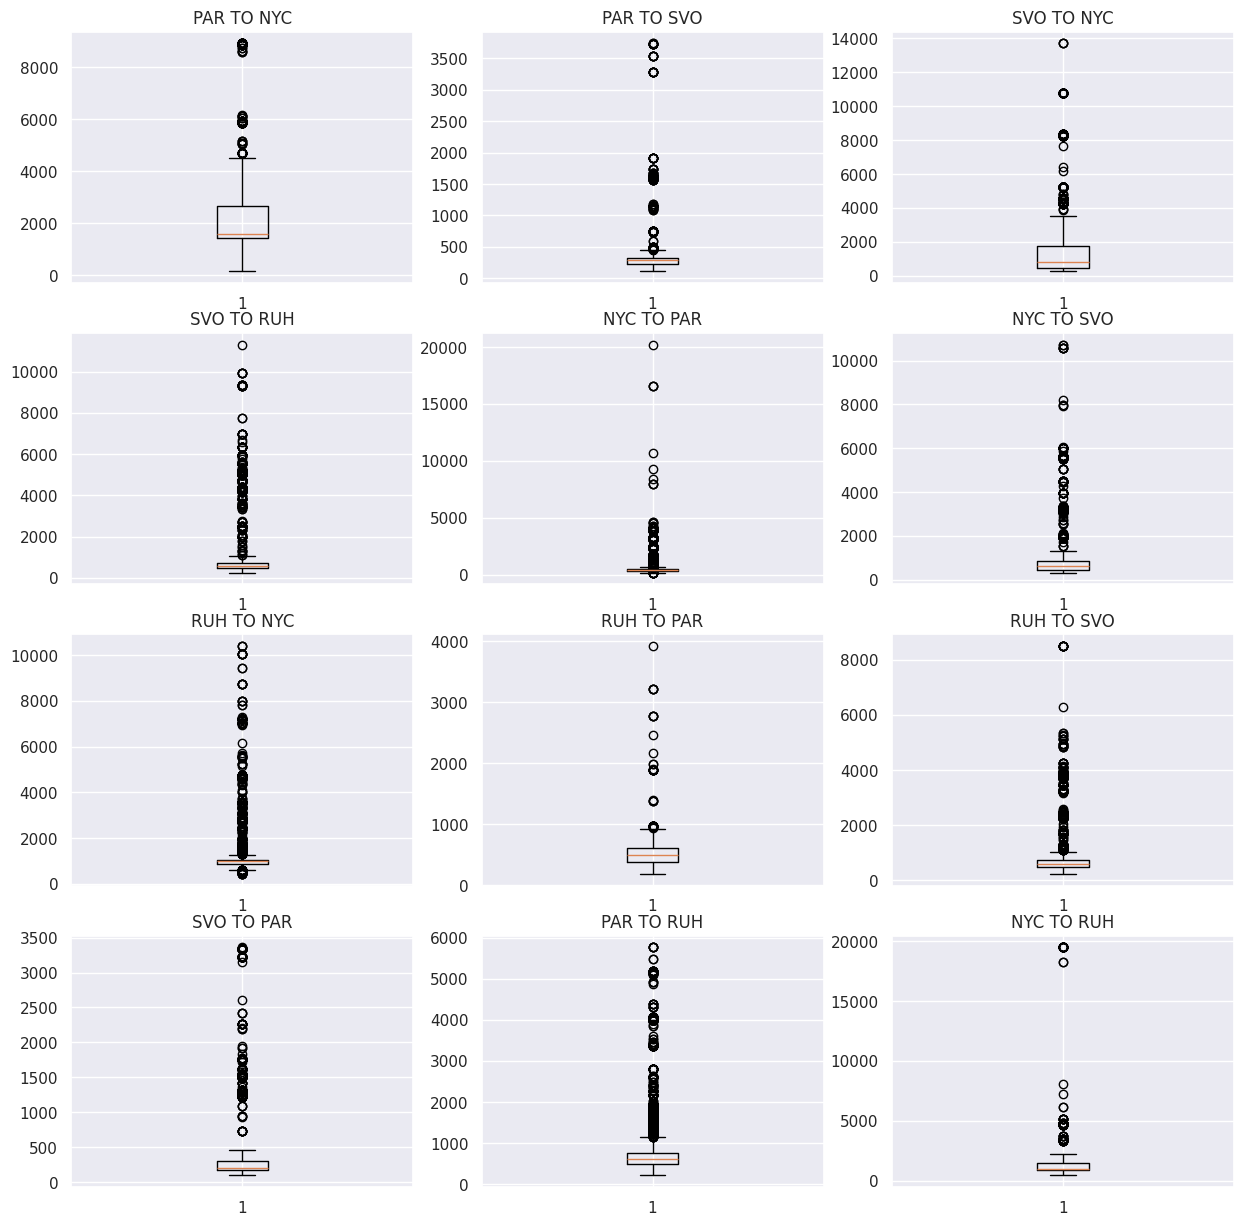

In [14]:
# boxplots for each route
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        prices = dfs[k]['Price']
        q1 = np.percentile(prices, 25)  # First quartile
        q2 = np.median(prices)          # Median (Q2)
        q3 = np.percentile(prices, 75)  # Third quartile

        print("Q1:", q1)
        print("Q2:", q2)
        print("Q3:", q3)
        print("------------------------------------------ ")

        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### It is apparent that all routes have outliers, so we'll deal with them by IQR

In [15]:
# get quantile to deal with outliers
lower = []
upper = []
for df in dfs:
    x = get_price_quantile(df['Price'])
    lower.append(x[0])
    upper.append(x[1])

In [16]:
# drop outliers
k = 0
for df in dfs:
    low = df['Price'] < lower[k]
    up = df['Price'] > upper[k]
    df['Price'] = df['Price'][~(low|up)]
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace=True)
    k+=1

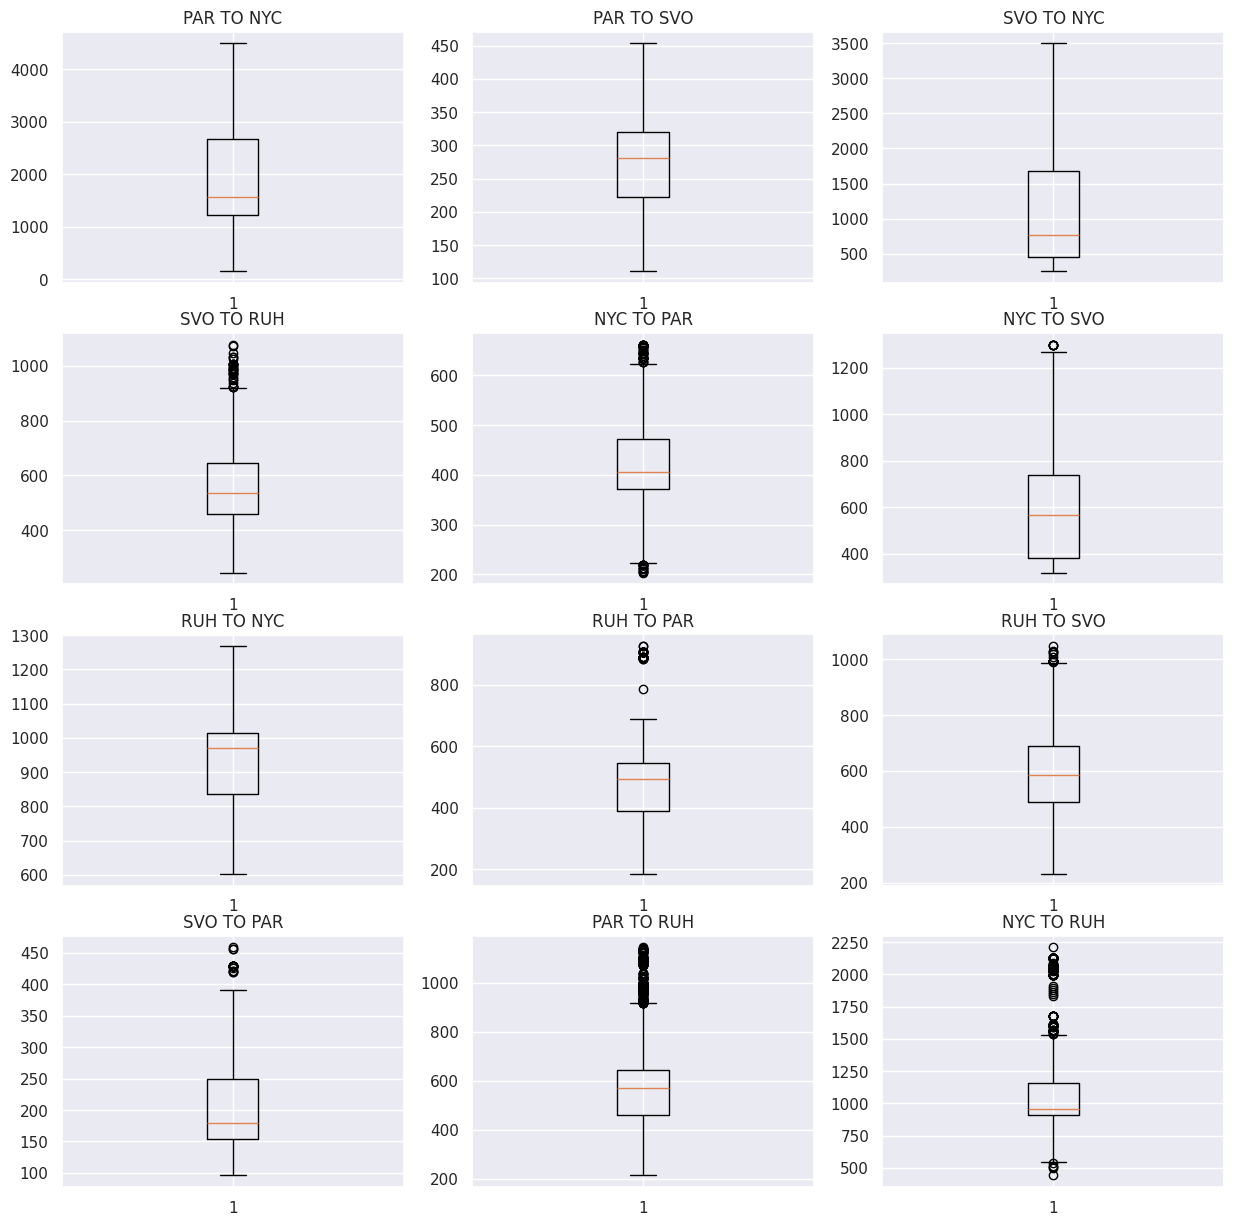

In [17]:
# boxplot for each route after dealing with outliers
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### Now the data is much better, the total dropped data is 5,266 rows out of 55,363.

In [18]:
# concat all routes into one dataframe
df = pd.concat(dfs)
df


,Airline,Source,Destination,Duration,Total stops,Price,Date,Average Price
0,TAP AIR PORTUGAL,PAR,NYC,770,1 stop,379.47,2022-02-01,441.343760
1,Iberia,PAR,NYC,520,nonstop,412.53,2022-02-01,1691.736202
2,"Air Transat, Air Canada",PAR,NYC,699,1 stop,321.33,2022-02-01,981.186149
3,Brussels Airlines,PAR,NYC,500,nonstop,436.27,2022-02-01,1068.789762
4,Air France,PAR,NYC,505,nonstop,446.67,2022-02-01,2308.301083
...,...,...,...,...,...,...,...,...
3046,Lufthansa,NYC,RUH,1165,2 stops,930.67,2022-04-22,941.326322
3047,Lufthansa,NYC,RUH,1130,2 stops,934.67,2022-04-22,941.326322
3048,SWISS,NYC,RUH,1145,2 stops,935.73,2022-04-22,932.670161
3049,Lufthansa,NYC,RUH,1095,2 stops,936.00,2022-04-22,941.326322


In [19]:
df.to_csv('ashraf.csv')

In [20]:
# the Airline column will be replaced by the average price per airline.
# df.drop("Airline", axis=1, inplace=True)
# performing OneHotEncoding on Source since it's nominal categorical data
source = df[["Source"]]
print(source)
source = pd.get_dummies(source, drop_first=True)
print("source------>")
print(source)

# performing OneHotEncoding on Destination since it's nominal categorical data
destination = df[["Destination"]]
destination = pd.get_dummies(destination, drop_first=True)
# performing LabelEncoder on Total stops since it's ordinal categorical data
df.replace({"nonstop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3}, inplace=True)
print("before")
print(df.columns)



df_final = pd.concat([df, source, destination], axis=1).reset_index(drop=True)

print("after")
print(df_final.columns)

# drop date since it'll not be used as a feature
df_final.drop(["Source", "Destination", "Date"], axis=1, inplace=True)

print(df_final.columns)


     Source
0       PAR
1       PAR
2       PAR
3       PAR
4       PAR
...     ...
3046    NYC
3047    NYC
3048    NYC
3049    NYC
3050    NYC

[50097 rows x 1 columns]
source------>
      Source_PAR  Source_RUH  Source_SVO
0           True       False       False
1           True       False       False
2           True       False       False
3           True       False       False
4           True       False       False
...          ...         ...         ...
3046       False       False       False
3047       False       False       False
3048       False       False       False
3049       False       False       False
3050       False       False       False

[50097 rows x 3 columns]
before
Index(['Airline', 'Source', 'Destination', 'Duration', 'Total stops', 'Price',
       'Date', 'Average Price'],
      dtype='object')
after
Index(['Airline', 'Source', 'Destination', 'Duration', 'Total stops', 'Price',
       'Date', 'Average Price', 'Source_PAR', 'Source_RUH', 'Source_SVO'

In [21]:
!pip show pandas

Name: pandas
Version: 2.2.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be u

In [22]:
# check for null values
df.isnull().sum()

,0
Airline,0
Source,0
Destination,0
Duration,0
Total stops,0
Price,0
Date,0
Average Price,0


## Handling Categorical Data: <a class="anchor" id="cat_data"></a>


In [23]:
# the Airline column will be replaced by the average price per airline.
df.drop("Airline", axis = 1, inplace = True)

In [24]:
# source
df["Source"].value_counts()

,count
Source,
PAR,23054
NYC,9411
RUH,9140
SVO,8492


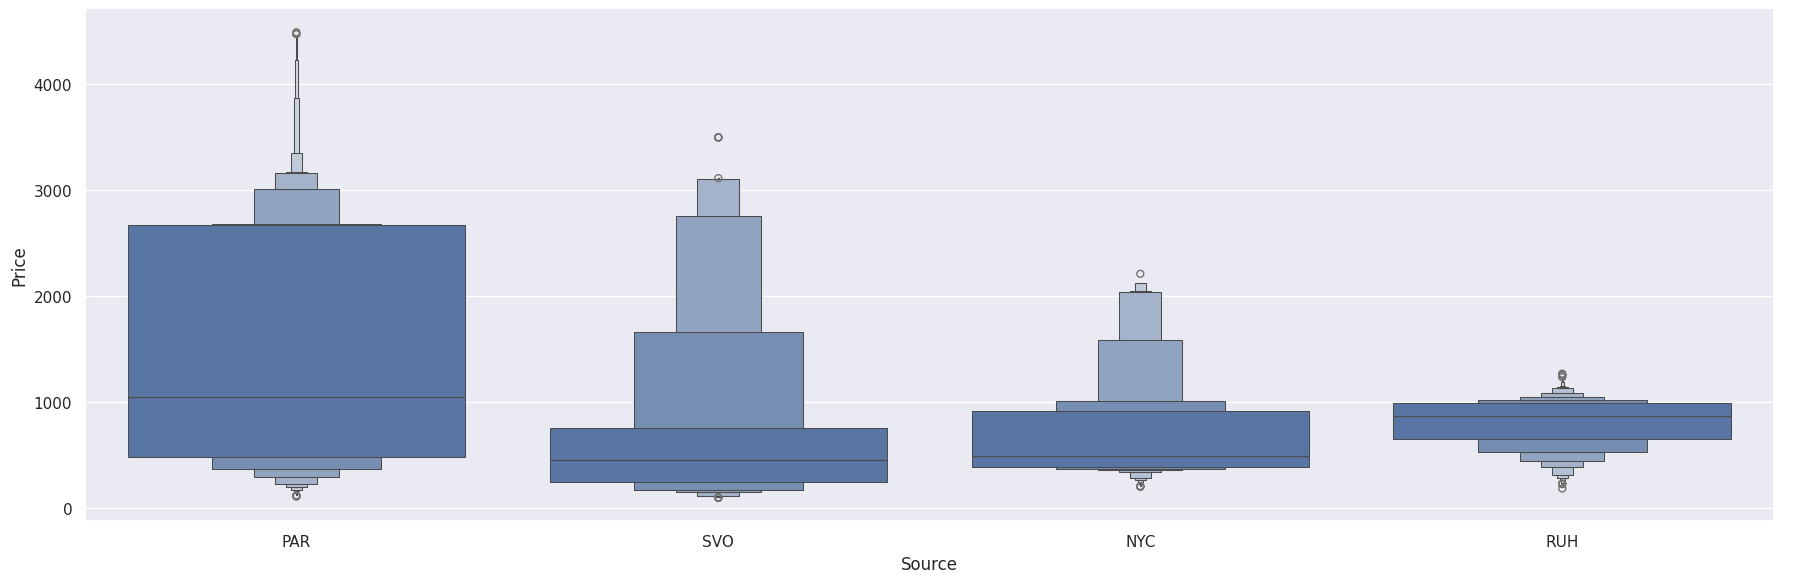

In [25]:
# source vs price
sns.catplot(y = "Price", x= "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [26]:
# performing OneHotEncoding on Source since it's nominal categorical data
source =df[["Source"]]
source =pd.get_dummies(source, drop_first=True)
source.head()

,Source_PAR,Source_RUH,Source_SVO
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [27]:
# destination
df["Destination"].value_counts()

,count
Destination,
NYC,24926
RUH,11046
PAR,8042
SVO,6083


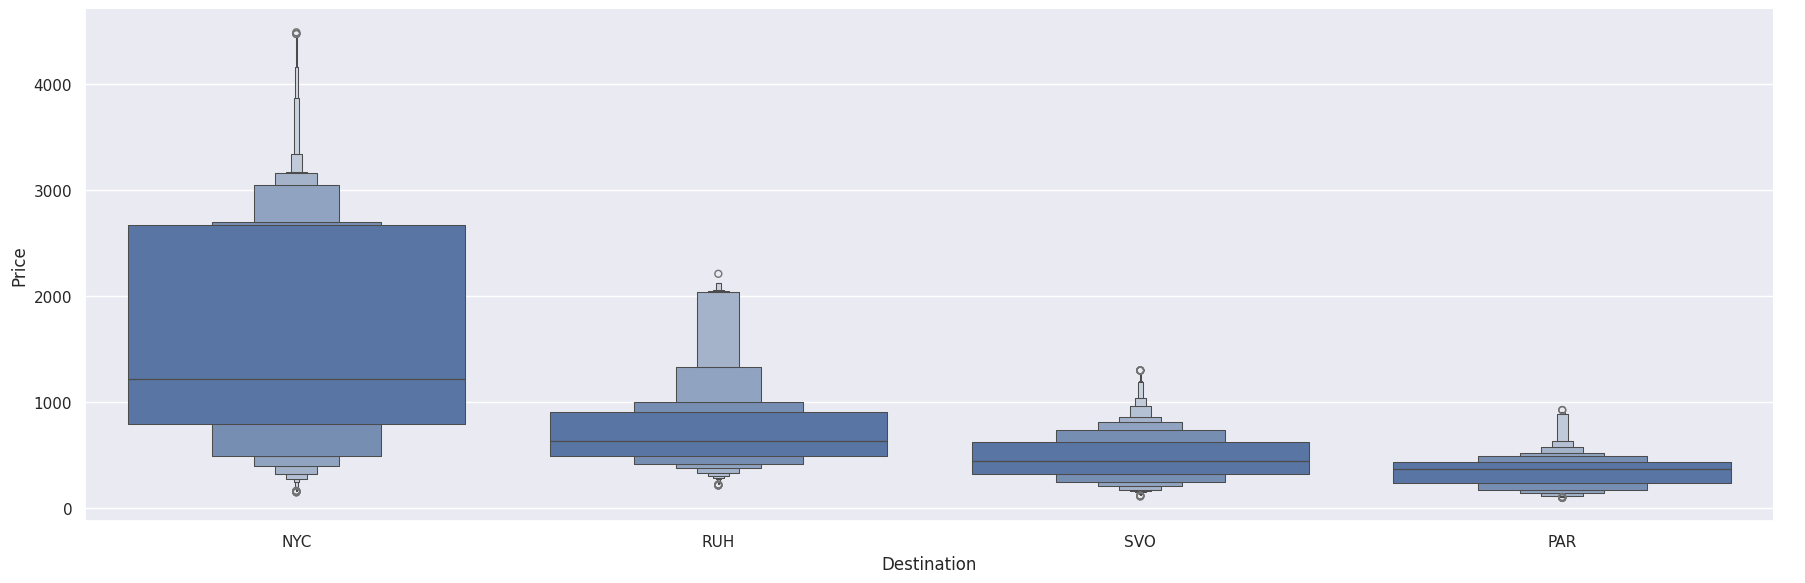

In [28]:
# destination vs price
sns.catplot(y = "Price", x= "Destination", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [29]:
# performing OneHotEncoding on Destination since it's nominal categorical data
destination = df[["Destination"]]
destination = pd.get_dummies(destination, drop_first=True)
destination.head()

,Destination_PAR,Destination_RUH,Destination_SVO
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


In [30]:
# total stops
print(df["Total stops"].value_counts())
df["Total stops"].unique()

Total stops
1 stop      27466
2 stops     18665
3 stops      1988
nonstop      1978
Name: count, dtype: int64


array(['1 stop ', 'nonstop ', '2 stops ', '3 stops '], dtype=object)

In [31]:
# performing LabelEncoder on Total stops since it's ordinal categorical data
df.replace({"nonstop ":0, "1 stop ": 1, "2 stops ": 2, "3 stops ":3}, inplace=True)

/tmp/ipython-input-3520626677.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"nonstop ":0, "1 stop ": 1, "2 stops ": 2, "3 stops ":3}, inplace=True)


In [32]:
final_df = pd.concat([df,source,destination], axis=1).reset_index(drop = True)

In [33]:
final_df

,Source,Destination,Duration,Total stops,Price,Date,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,PAR,NYC,770,1,379.47,2022-02-01,441.343760,True,False,False,False,False,False
1,PAR,NYC,520,0,412.53,2022-02-01,1691.736202,True,False,False,False,False,False
2,PAR,NYC,699,1,321.33,2022-02-01,981.186149,True,False,False,False,False,False
3,PAR,NYC,500,0,436.27,2022-02-01,1068.789762,True,False,False,False,False,False
4,PAR,NYC,505,0,446.67,2022-02-01,2308.301083,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50092,NYC,RUH,1165,2,930.67,2022-04-22,941.326322,False,False,False,False,True,False
50093,NYC,RUH,1130,2,934.67,2022-04-22,941.326322,False,False,False,False,True,False
50094,NYC,RUH,1145,2,935.73,2022-04-22,932.670161,False,False,False,False,True,False
50095,NYC,RUH,1095,2,936.00,2022-04-22,941.326322,False,False,False,False,True,False


In [34]:
# drop date since it'll not be used as a feature
final_df.drop(["Source","Destination","Date"], axis=1, inplace=True)

In [35]:
final_df

,Duration,Total stops,Price,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,770,1,379.47,441.343760,True,False,False,False,False,False
1,520,0,412.53,1691.736202,True,False,False,False,False,False
2,699,1,321.33,981.186149,True,False,False,False,False,False
3,500,0,436.27,1068.789762,True,False,False,False,False,False
4,505,0,446.67,2308.301083,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
50092,1165,2,930.67,941.326322,False,False,False,False,True,False
50093,1130,2,934.67,941.326322,False,False,False,False,True,False
50094,1145,2,935.73,932.670161,False,False,False,False,True,False
50095,1095,2,936.00,941.326322,False,False,False,False,True,False


In [36]:
final_df.shape

(50097, 10)

In [37]:
final_df.isnull().sum()

,0
Duration,0
Total stops,0
Price,0
Average Price,0
Source_PAR,0
Source_RUH,0
Source_SVO,0
Destination_PAR,0
Destination_RUH,0
Destination_SVO,0


## Features: <a class="anchor" id="features"></a>

#### After constructing the final dataframe with all numerical values, now we can analyze the features that will be used for the regressions models

In [38]:
final_df.columns

Index(['Duration', 'Total stops', 'Price', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO'],
      dtype='object')

In [39]:
X = final_df[['Duration', 'Total stops', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO']]

y = final_df["Price"]

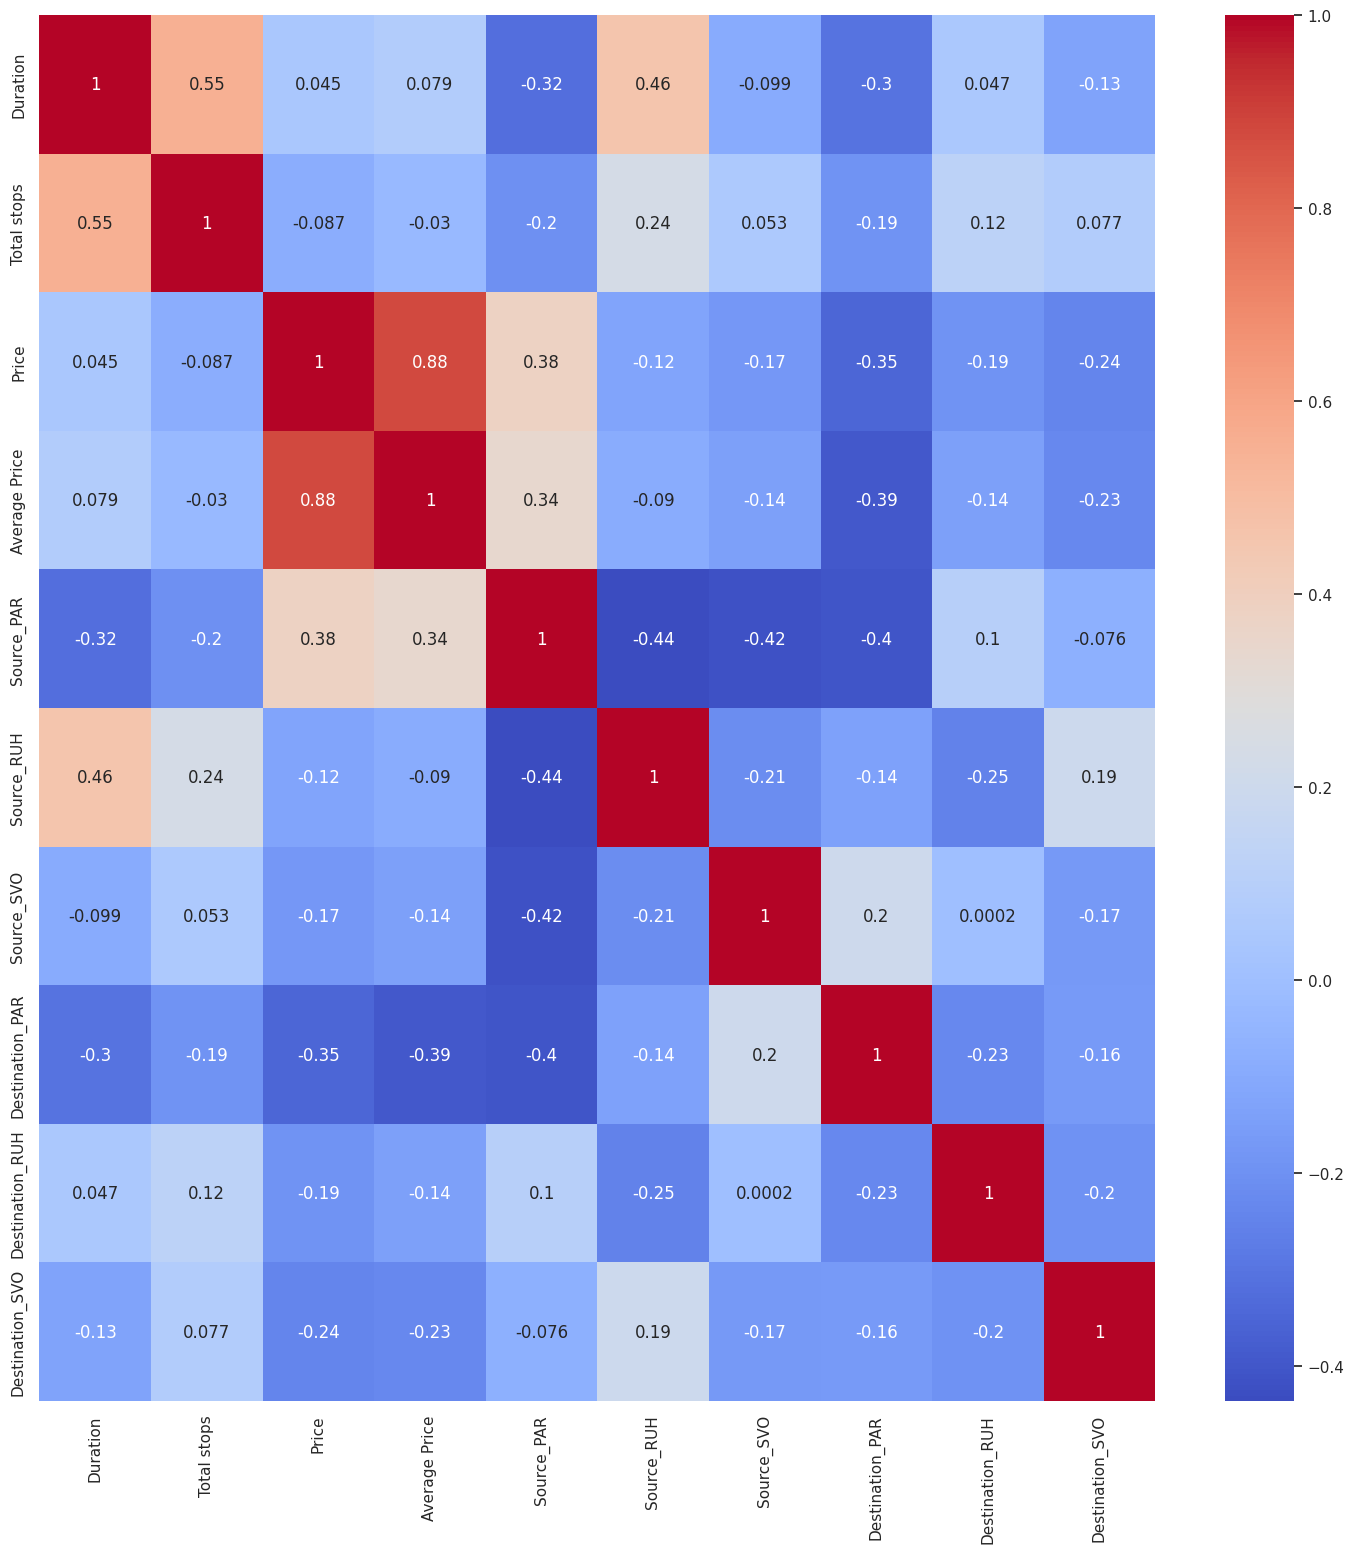

In [40]:
plt.figure(figsize = (18,18))

sns.heatmap(final_df.corr(),annot= True, cmap = "coolwarm")

plt.show()

In [41]:
# getting feature importance to the target variable "Price".
selection =ExtraTreesRegressor()
selection.fit(X,y)
selection.feature_importances_

array([0.03970739, 0.0167485 , 0.76835207, 0.07966174, 0.00709476,
       0.01168941, 0.02401951, 0.03998216, 0.01274446])

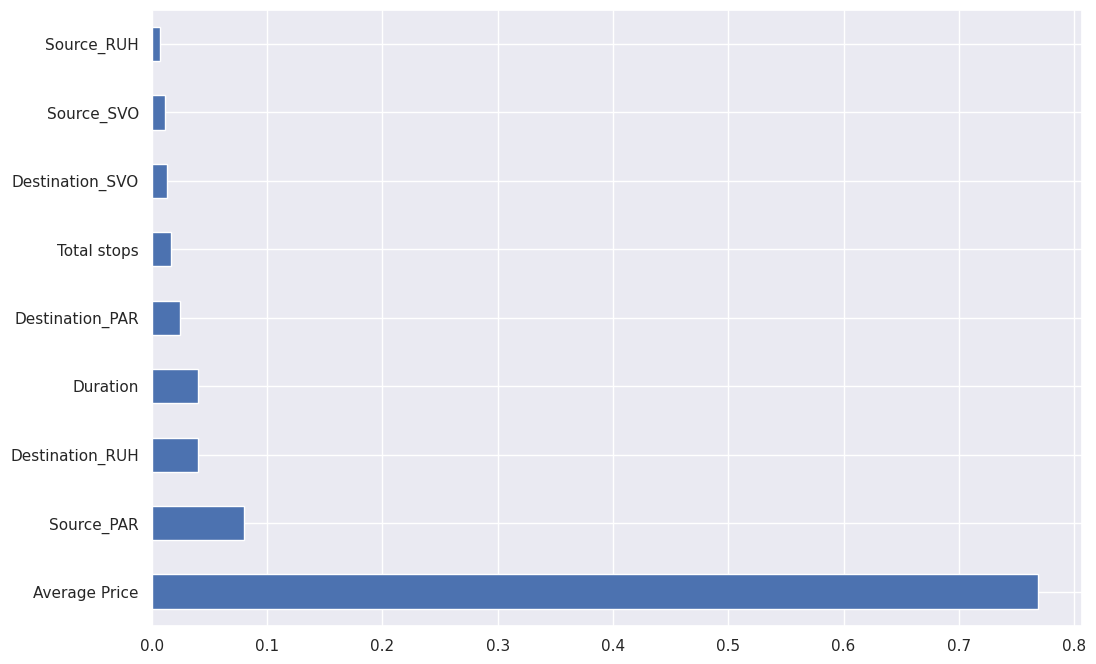

In [42]:
# plotting graph of important features
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_,index = X.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.show()

## Modeling: <a class="anchor" id="modeling"></a>

### Splitting the data

In [43]:
# 60% Train - 20% Val - 20% Test

X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)


In [44]:
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')

In [45]:
X_train.__class__

pandas.core.frame.DataFrame

### Defining a function to get metrics for val set

In [46]:
def get_metrics(model):
    print(f'Train score {model.score(X_train, y_train)}')
    print(f'Val score {model.score(X_val, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val))))

### Baseline Linear Regression

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)
score = lr.score(X_val, y_val)
get_metrics(lr)

Train score 0.8016835008740377
Val score 0.804685778651127
MAE: 223.25587208809205
MSE: 147387.5688649003
RMSE: 383.9108866194085


### Polynomial

In [48]:
for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("-"*20)
    print("Degree", degree)
    get_metrics(poly)

--------------------
Degree 1
Train score 0.8016835008740377
Val score 0.8046857786511264
MAE: 223.25587208810185
MSE: 147387.56886490074
RMSE: 383.91088661940904
--------------------
Degree 2
Train score 0.8566032793543306
Val score 0.8585585444454351
MAE: 176.57589766668818
MSE: 106734.22614558862
RMSE: 326.70204490573457
--------------------
Degree 3
Train score 0.8749519069848708
Val score 0.8783844182819227
MAE: 158.21608895170388
MSE: 91773.27079271308
RMSE: 302.9410351746905
--------------------
Degree 4
Train score 0.8767882663742663
Val score 0.8798330831987995
MAE: 155.939037516843
MSE: 90680.08260229985
RMSE: 301.13133779515516
--------------------
Degree 5
Train score 0.8798909442168218
Val score 0.8823674417997083
MAE: 154.68534280493165
MSE: 88767.61073906267
RMSE: 297.93893793705894


### Lasso

In [49]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
get_metrics(lasso_model)

Train score 0.8014923231619172
Val score 0.8046202176607057
MAE: 221.57074865426128
MSE: 147437.0423488271
RMSE: 383.97531476493003


### Ridge

In [50]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
get_metrics(ridge_model)

Train score 0.8016834851862666
Val score 0.804686659015666
MAE: 223.2395337419418
MSE: 147386.90452623504
RMSE: 383.91002139334034


### ElasticNet

In [51]:
EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train, y_train)
EN_model.score(X_val, y_val)
get_metrics(EN_model)

Train score 0.7869486909100185
Val score 0.7915544889599926
MAE: 221.9235826864628
MSE: 157296.67251475694
RMSE: 396.60644537722396


### Random Forest

In [52]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
get_metrics(rf)

Train score 0.9631563862301266
Val score 0.9496232937696165
MAE: 59.90461720385885
MSE: 38015.15428543753
RMSE: 194.97475294365046


### Feature Scaling

In [53]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [54]:
X_test

,Duration,Total stops,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
28737,1115,2,577.673656,False,False,False,False,False,True
26701,1000,2,427.717136,False,False,False,True,False,False
47122,1215,2,976.683457,False,False,False,False,True,False
6109,660,1,1200.705114,True,False,False,False,False,False
99,971,2,1363.829357,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
17438,1080,2,4220.968312,False,False,True,False,False,False
3534,860,1,468.262212,True,False,False,False,False,False
8695,755,1,1200.705114,True,False,False,False,False,False
30177,1340,2,1091.776454,False,True,False,False,False,False


In [55]:
# function to get metrics for scaled features
def scaled_metrics(model):
    print(f'Train score {model.score(X_train_scaled, y_train)}')
    print(f'Val score {model.score(X_val_scaled, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val_scaled)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val_scaled)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val_scaled))))


## Baseline: Linear Regression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
score = lr.score(X_val_scaled, y_val)
print("LR")
scaled_metrics(lr)
print("-"*50)

## Polynomial

for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("Polynomial - Degree", degree)
    scaled_metrics(poly)
    print("-"*50)

## Lasso

lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
print("Lasso")
scaled_metrics(lasso_model)
print("-"*50)

## Ridge

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
print("Ridge")
scaled_metrics(ridge_model)
print("-"*50)

## ElasticNet

EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train_scaled, y_train)
EN_model.score(X_val_scaled, y_val)
print("ElasticNet")
scaled_metrics(EN_model)
print("-"*50)

## Random Forest
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print("Random Forest")
scaled_metrics(rf)

LR
Train score 0.8016835008740377
Val score 0.804685778651127
MAE: 223.255872088092
MSE: 147387.56886490027
RMSE: 383.9108866194084
--------------------------------------------------
Polynomial - Degree 1
Train score -0.33351683189299863
Val score -0.32858043317183183
MAE: 778.3811775216004
MSE: 1002570.3132845751
RMSE: 1001.2843318880882
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Polynomial - Degree 2
Train score -6.700012007865975
Val score -6.673337752527487
MAE: 1834.1317425869395
MSE: 5790436.50080225
RMSE: 2406.3325831651473
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Polynomial - Degree 3
Train score -1.2501285544985965
Val score -1.25209581560045
MAE: 1022.4347759202773
MSE: 1699471.368852683
RMSE: 1303.637744487587
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Polynomial - Degree 4


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Train score -0.8245164117571506
Val score -0.8219212452256126


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


MAE: 797.5704333925387
MSE: 1374854.0231357012


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


RMSE: 1172.5416935596368
--------------------------------------------------
Polynomial - Degree 5


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Train score -0.7264417269154644
Val score -0.7252718815030472


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


MAE: 758.0043388512354
MSE: 1301920.7023921802


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


RMSE: 1141.0173979357985
--------------------------------------------------
Lasso
Train score 0.8016647283525604
Val score 0.8047053548291917
MAE: 222.7883035032817
MSE: 147372.7963343969
RMSE: 383.8916466066915
--------------------------------------------------
Ridge
Train score 0.8016835000179079
Val score 0.8046858299190134
MAE: 223.25813464436652
MSE: 147387.5301772457
RMSE: 383.91083623316194
--------------------------------------------------
ElasticNet
Train score 0.7331856706067331
Val score 0.7360747493033366
MAE: 306.1137229877417
MSE: 199162.6661571052
RMSE: 446.2764458910029
--------------------------------------------------
Random Forest
Train score -1.0749258580225032


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Val score -1.0686110385208738
MAE: 896.4535139675494
MSE: 1561010.5080371685


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE: 1249.4040611576258


#### Feature scaling was of no use, it did not improve anything.



**<br>From the above analysis, we can see that the random forest model performed the best with:</br>**

**Train score 0.9648778537711422**
**<br>Val score 0.9448134490695079</br>**
**<br>MAE: 61.717733027545194</br>**
**<br>MSE: 40035.31608101726</br>**
**<br>RMSE: 200.0882707232417</br>**

**So, we'll select it as our model.**

In [56]:
# retraining the random forest model on train + val, and scoring on test

X_train_val = pd.concat([X_train,X_val])
y_train_val = pd.concat([y_train,y_val])

rf = RandomForestRegressor()
rf.fit(X_train_val,y_train_val)

print(f'Train score {rf.score(X_train_val, y_train_val)}')
print(f'Test score {rf.score(X_test, y_test)}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf.predict(X_test))))

Train score 0.9628104731894381
Test score 0.9480102845837275
MAE: 60.93376441570389
MSE: 37702.15690630213
RMSE: 194.1704326263454


In [57]:
X_test

,Duration,Total stops,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
28737,1115,2,577.673656,False,False,False,False,False,True
26701,1000,2,427.717136,False,False,False,True,False,False
47122,1215,2,976.683457,False,False,False,False,True,False
6109,660,1,1200.705114,True,False,False,False,False,False
99,971,2,1363.829357,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
17438,1080,2,4220.968312,False,False,True,False,False,False
3534,860,1,468.262212,True,False,False,False,False,False
8695,755,1,1200.705114,True,False,False,False,False,False
30177,1340,2,1091.776454,False,True,False,False,False,False


In [58]:
y_train_val_pred = rf.predict(X_train_val)
y_test_pred = rf.predict(X_test)

In [59]:
first_row = X_test.iloc[0]
first_row



,28737
Duration,1115
Total stops,2
Average Price,577.673656
Source_PAR,False
Source_RUH,False
Source_SVO,False
Destination_PAR,False
Destination_RUH,False
Destination_SVO,True


In [60]:
first_row.__class__

pandas.core.series.Series

In [61]:

x_row = np.array(first_row).reshape(1, -1)

In [62]:
x_row

array([[np.int64(1115), np.int64(2), np.float64(577.673655737705),
        np.False_, np.False_, np.False_, np.False_, np.False_, np.True_]],
      dtype=object)

In [63]:
predicted = rf.predict(x_row)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [64]:
predicted

array([479.29703129])

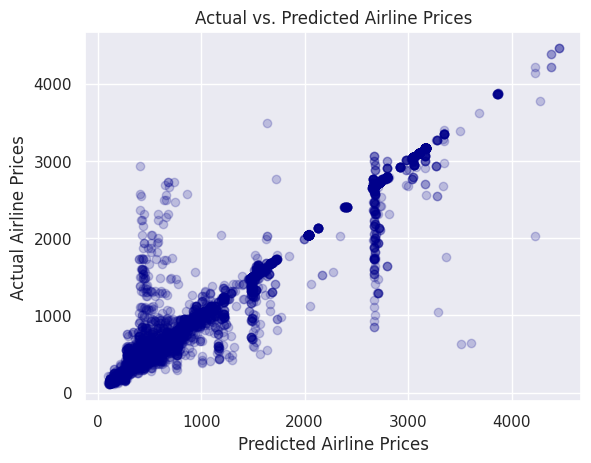

In [65]:
plt.scatter(y_test,y_test_pred,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

### Hyperparameter Tuning

In [66]:
# randomized search CV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [67]:
# create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [68]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, n_jobs = 1)

In [69]:
rf_random.fit(X_train_val,y_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=1200; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimat

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [70]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20}

In [71]:
prediction = rf_random.predict(X_test)

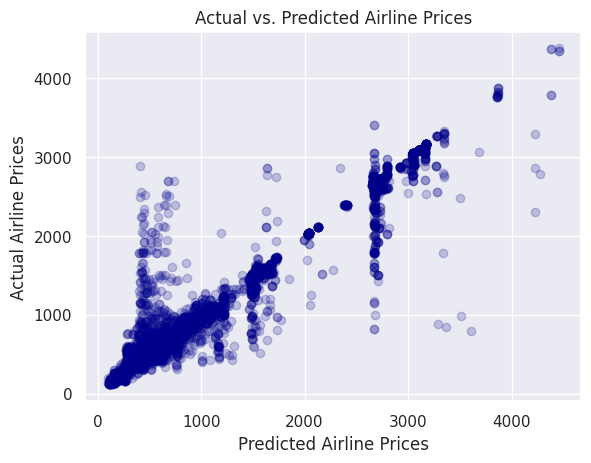

In [72]:
plt.scatter(y_test,prediction,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

In [73]:
print("MAE:" , metrics.mean_absolute_error(y_test,prediction))
print("MSE:" , metrics.mean_squared_error(y_test,prediction))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE: 72.93288674444847
MSE: 41061.85687885264
RMSE: 202.63725441994282


#### Therefore, hyperparameter tuning did not improve the model

In [74]:
test_df = pd.DataFrame({
    "Predicted Price" : rf.predict(X_test),
    "Actual Price" : y_test,
}).reset_index(drop = True)

test_df

,Predicted Price,Actual Price
0,479.297031,1008.80
1,426.740757,425.33
2,954.130000,954.13
3,614.708838,488.53
4,1494.374565,1495.20
...,...,...
10015,438.459869,481.87
10016,559.320090,574.40
10017,1013.005105,1210.93
10018,989.589827,928.53


## Saving The Final Model: <a class="anchor" id="model"></a>

In [77]:
# save the model
file = open('rf_flight_prediction.pkl', 'wb')
pkl.dump(rf, file)

In [78]:
# open the model
model = open('rf_flight_prediction.pkl','rb')
rf_flight_prediction = pkl.load(model)

In [79]:
print(f'R2 score {metrics.r2_score(y_test,rf_flight_prediction.predict(X_test))}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf_flight_prediction.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test))))

R2 score 0.9480102845837275
MAE: 60.93376441570389
MSE: 37702.15690630213
RMSE: 194.1704326263454


### Therefore, the final model is able to predict flight ticket prices within around  ≈ $61.87